In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/micro-organism-classifier/server-side

/content/drive/MyDrive/Colab Notebooks/micro-organism-classifier/server-side


In [3]:
# navigate to root directory of current file in order to access other files relatively
%cd /content/drive/MyDrive/Colab\ Notebooks/micro-organism-classifier/server-side/modelling

/content/drive/MyDrive/Colab Notebooks/micro-organism-classifier/server-side/modelling


In [4]:
!pip install -U keras-tuner
!pip install seaborn
!pip install numpy
!pip install pillow
!pip install scikit-learn
!pip install split-folders
# !pip install nltk
# !pip install csv
# !pip install tqdm
# !pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.0 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
from PIL import Image
import tensorflow as tf

from utilities.loaders import (
    create_image_set,
    create_metrics_df,
    create_classified_df)

from utilities.preprocessors import (
    one_hot_encode,
    re_encode_sparse_labels,
    decode_one_hot,
    translate_labels,
    encode_image,
    standardize_image,
    rejoin_batches,
    activate_logits)

from utilities.visualizers import (
    data_split_metric_values,
    multi_class_heatmap,
    view_metric_values,
    view_classified_labels,
    view_label_freq,
    ModelResults,
    view_images,
    view_all_splits_results,
    show_image
)

from models.arcs import (
    load_baseline_a,
    load_baseline_b,
    train_model,
    compile_model,
    load_tuner,
    train_tuner,
    MOClassifierHyperModel
)

%load_ext autoreload
%autoreload 2

In [6]:
train_gen, cross_gen, test_gen = create_image_set('./data/Micro_Organism')

Copying files: 789 files [06:47,  1.94 files/s]

Found 549 images belonging to 8 classes.
Found 114 images belonging to 8 classes.
Found 126 images belonging to 8 classes.


In [7]:
len(train_gen)

5

In [8]:
#### It is imperative that we rejoin the batches after generating a batch generator of our training examples

In [9]:
X_trains, Y_trains = rejoin_batches(train_gen)
X_cross, Y_cross = rejoin_batches(cross_gen)
X_tests, Y_tests = rejoin_batches(test_gen)

549
114
126


In [10]:
for i in range(len(train_gen)):
    image, label = next(train_gen)
    if i == 0:
        # select an number of training labels from a batch
        print(label[0:5])
    print(image.shape)
    print(label.shape)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]
(128, 256, 256, 3)
(128, 8)
(128, 256, 256, 3)
(128, 8)
(128, 256, 256, 3)
(128, 8)
(128, 256, 256, 3)
(128, 8)
(37, 256, 256, 3)
(37, 8)


In [11]:
input_shape = image.shape[1:]
input_shape

(256, 256, 3)

In [12]:
train_gen.class_indices

{'Amoeba': 0,
 'Euglena': 1,
 'Hydra': 2,
 'Paramecium': 3,
 'Rod_bacteria': 4,
 'Spherical_bacteria': 5,
 'Spiral_bacteria': 6,
 'Yeast': 7}

In [13]:
classes = list(train_gen.class_indices.keys())
classes

['Amoeba',
 'Euglena',
 'Hydra',
 'Paramecium',
 'Rod_bacteria',
 'Spherical_bacteria',
 'Spiral_bacteria',
 'Yeast']

In [14]:
n_classes = len(classes)

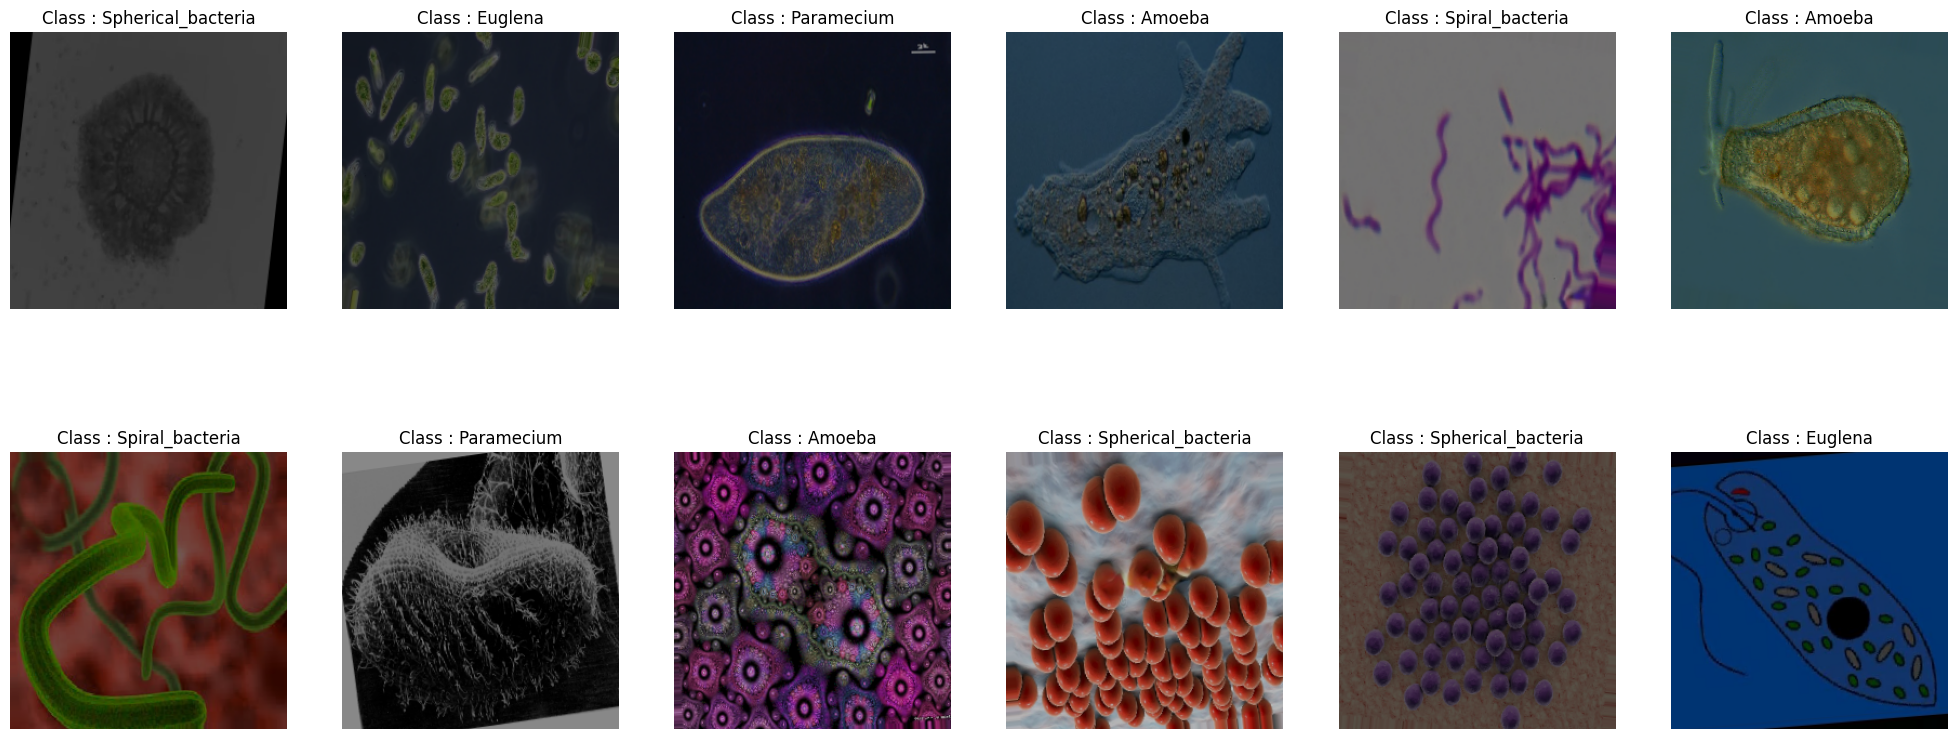

In [15]:
view_images(train_gen, img_title='training split images', save_img=True)

In [17]:
baseline_raw_model = load_baseline_b(n_classes=n_classes, input_shape=input_shape)

87910968/87910968 [==============================] - 1s 0us/step


In [18]:
baseline_compiled_model = compile_model(baseline_raw_model, 0.0001)

Model: "architecture-inception-v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 batch_normalization_94 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 activation_94 (Activation)  (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                         

In [19]:
baseline_history, baseline_trained_model = train_model(baseline_compiled_model, train_gen, cross_gen, 50)

Epoch 1/50

Epoch 1: val_categorical_accuracy improved from -inf to 0.45614, saving model to ./saved/models/test_architecture-inception-v3_01_0.46.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 - 144s - loss: 2.0371 - categorical_accuracy: 0.2842 - categorical_crossentropy: 2.0371 - val_loss: 1.7514 - val_categorical_accuracy: 0.4561 - val_categorical_crossentropy: 1.7514 - 144s/epoch - 29s/step
Epoch 2/50

Epoch 2: val_categorical_accuracy improved from 0.45614 to 0.48246, saving model to ./saved/models/test_architecture-inception-v3_02_0.48.h5
5/5 - 140s - loss: 1.0335 - categorical_accuracy: 0.6576 - categorical_crossentropy: 1.0335 - val_loss: 1.7544 - val_categorical_accuracy: 0.4825 - val_categorical_crossentropy: 1.7544 - 140s/epoch - 28s/step
Epoch 3/50

Epoch 3: val_categorical_accuracy improved from 0.48246 to 0.53509, saving model to ./saved/models/test_architecture-inception-v3_03_0.54.h5
5/5 - 160s - loss: 0.7179 - categorical_accuracy: 0.7942 - categorical_crossentropy: 0.7179 - val_loss: 1.5561 - val_categorical_accuracy: 0.5351 - val_categorical_crossentropy: 1.5561 - 160s/epoch - 32s/step
Epoch 4/50

Epoch 4: val_categorical_accuracy improved from 0.53509

#### Make sure after training to load the best saved model

In [20]:
baseline_trained_model = tf.keras.models.load_model('./saved/models/test_architecture-inception-v3_10_0.66.h5')

#### Here batches of training data are rejoined once again after prediction

In [21]:
logits_pred_train = baseline_trained_model.predict(train_gen)
logits_pred_cross = baseline_trained_model.predict(cross_gen)
logits_pred_test = baseline_trained_model.predict(test_gen)

4/4 [==============================] - 24s 5s/step


In [22]:
logits_pred_train

array([[ 8.596932  , -2.5337577 , -1.8496153 , ...,  1.5757467 ,
        -0.14412826, -0.9517995 ],
       [-1.9171867 ,  6.7697806 ,  4.271553  , ..., -2.2220314 ,
        -0.10280643, -2.4206495 ],
       [ 1.8617469 , -0.29126763,  2.3953123 , ..., -0.80920905,
        -0.24408883, -1.4394187 ],
       ...,
       [ 1.2582443 , -3.1168146 , -0.66947675, ...,  6.3115697 ,
        -2.1124861 , -0.5445615 ],
       [ 0.4222295 ,  5.6561675 , -2.5677352 , ..., -0.35999075,
        -1.5187007 , -0.64844894],
       [ 1.7350905 , -1.41814   , -0.49445483, ..., -0.22187462,
         0.53145516,  2.7005043 ]], dtype=float32)

In [23]:
logits_pred_train.shape

(549, 8)

In [24]:
logits_pred_cross.shape

(114, 8)

In [25]:
logits_pred_test.shape

(126, 8)

In [31]:
act_preds_train = activate_logits(logits_pred_train)
act_preds_cross = activate_logits(logits_pred_cross)
act_preds_test = activate_logits(logits_pred_test)

In [32]:
act_preds_train

<tf.Tensor: shape=(549, 8), dtype=float32, numpy=
array([[9.9864846e-01, 1.4635770e-05, 2.9009132e-05, ..., 8.9155958e-04,
        1.5966818e-04, 7.1195260e-05],
       [1.5571198e-04, 9.2262292e-01, 7.5867847e-02, ..., 1.1479686e-04,
        9.5564709e-04, 9.4117713e-05],
       [3.1214714e-01, 3.6250755e-02, 5.3221107e-01, ..., 2.1596229e-02,
        3.8002007e-02, 1.1499563e-02],
       ...,
       [6.2877806e-03, 7.9146790e-05, 9.1474230e-04, ..., 9.8430300e-01,
        2.1607660e-04, 1.0364513e-03],
       [5.2536400e-03, 9.8521453e-01, 2.6420149e-04, ..., 2.4029601e-03,
        7.5426709e-04, 1.8008215e-03],
       [2.1700607e-01, 9.2691798e-03, 2.3344932e-02, ..., 3.0660037e-02,
        6.5123789e-02, 5.6983060e-01]], dtype=float32)>

In [34]:
Y_preds_train = decode_one_hot(act_preds_train)
Y_preds_cross = decode_one_hot(act_preds_cross)
Y_preds_test = decode_one_hot(act_preds_test)

In [35]:
Y_preds_train

array([0, 1, 2, 2, 5, 2, 1, 6, 1, 3, 6, 3, 0, 1, 1, 1, 7, 6, 5, 3, 3, 4,
       5, 3, 6, 4, 5, 6, 4, 7, 3, 6, 5, 4, 0, 3, 6, 6, 0, 1, 3, 5, 5, 0,
       1, 3, 7, 0, 1, 4, 1, 5, 7, 1, 0, 1, 1, 1, 3, 3, 2, 1, 6, 3, 3, 3,
       0, 2, 0, 1, 1, 4, 7, 6, 3, 3, 2, 3, 3, 2, 3, 0, 6, 5, 1, 0, 7, 7,
       1, 7, 7, 6, 1, 3, 2, 7, 1, 7, 1, 4, 2, 4, 3, 0, 1, 5, 0, 4, 5, 6,
       1, 7, 2, 0, 6, 7, 6, 7, 0, 6, 0, 1, 1, 2, 1, 0, 5, 1, 0, 6, 4, 5,
       3, 4, 1, 6, 3, 7, 1, 6, 3, 1, 4, 4, 1, 7, 6, 2, 3, 5, 7, 1, 2, 5,
       3, 4, 3, 0, 4, 2, 1, 6, 1, 3, 3, 6, 7, 6, 1, 1, 5, 3, 3, 4, 0, 2,
       1, 4, 7, 1, 6, 4, 0, 1, 4, 1, 1, 2, 3, 1, 1, 3, 3, 3, 0, 0, 0, 5,
       6, 5, 1, 3, 2, 3, 4, 1, 1, 1, 7, 1, 1, 6, 1, 1, 5, 5, 3, 2, 2, 2,
       3, 5, 7, 0, 2, 1, 5, 1, 3, 1, 7, 5, 1, 7, 2, 3, 1, 2, 1, 7, 6, 5,
       1, 4, 5, 5, 2, 7, 1, 4, 4, 1, 4, 2, 5, 4, 3, 7, 3, 3, 5, 1, 5, 4,
       1, 3, 0, 6, 0, 1, 4, 3, 2, 3, 4, 0, 1, 1, 7, 5, 3, 2, 3, 4, 2, 2,
       5, 1, 3, 1, 1, 1, 7, 5, 0, 3, 7, 5, 1, 1, 6,

In [36]:
Y_preds_train.shape

(549,)

In [37]:
baseline_train_metric_values = baseline_trained_model.evaluate(train_gen)

5/5 [==============================] - 128s 22s/step - loss: 0.2380 - categorical_accuracy: 0.9490 - categorical_crossentropy: 0.2380


In [38]:
baseline_cross_metric_values = baseline_trained_model.evaluate(cross_gen)

4/4 [==============================] - 28s 4s/step - loss: 1.2153 - categorical_accuracy: 0.6140 - categorical_crossentropy: 1.2153


In [39]:
baseline_test_metric_values = baseline_trained_model.evaluate(test_gen)

4/4 [==============================] - 23s 5s/step - loss: 1.0291 - categorical_accuracy: 0.6746 - categorical_crossentropy: 1.0291


In [41]:
baseline_metrics_df = create_metrics_df(baseline_train_metric_values,
                  baseline_cross_metric_values,
                  baseline_test_metric_values,
                  metrics=['loss', 'categorical_accuracy', 'categorical_crossentropy'])
baseline_metrics_df

,data_split,loss,categorical_accuracy,categorical_crossentropy
0,training,0.237975,0.948998,0.237975
1,validation,1.215314,0.614035,1.215314
2,testing,1.029135,0.674603,1.029135


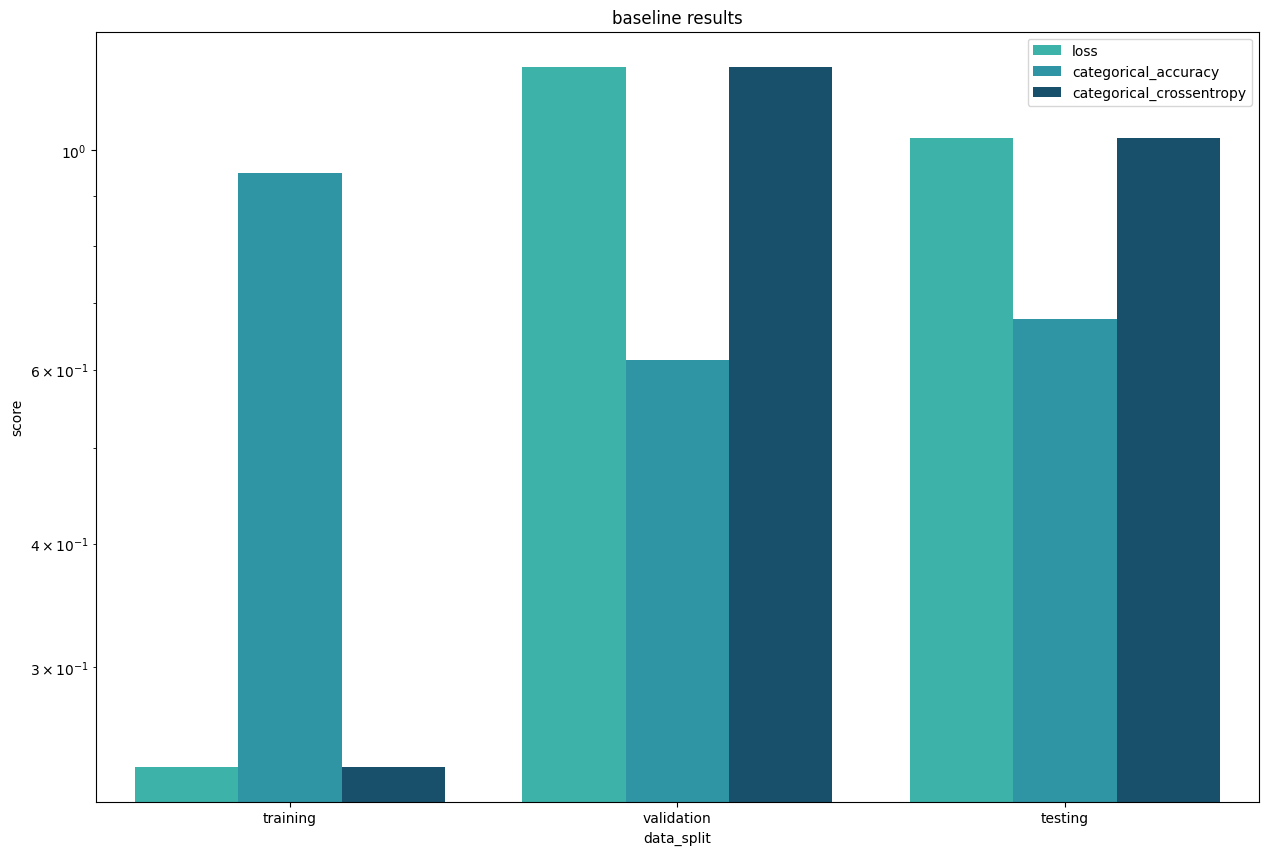

In [42]:
view_metric_values(baseline_metrics_df, img_title='baseline results', save_img=True)

        loss  categorical_accuracy  categorical_crossentropy  val_loss  \
0   2.037146              0.284153                  2.037146  1.751374   
1   1.033467              0.657559                  1.033467  1.754377   
2   0.717932              0.794171                  0.717932  1.556059   
3   0.635252              0.821494                  0.635252  1.580820   
4   0.474211              0.883424                  0.474211  1.494894   
5   0.422130              0.894353                  0.422130  1.310804   
6   0.353907              0.939891                  0.353907  1.342947   
7   0.333784              0.914390                  0.333784  1.275079   
8   0.268657              0.948998                  0.268657  1.188001   
9   0.235456              0.954463                  0.235456  1.190997   
10  0.207582              0.961749                  0.207582  1.237391   
11  0.198923              0.958106                  0.198923  1.210530   
12  0.162866              0.978142    

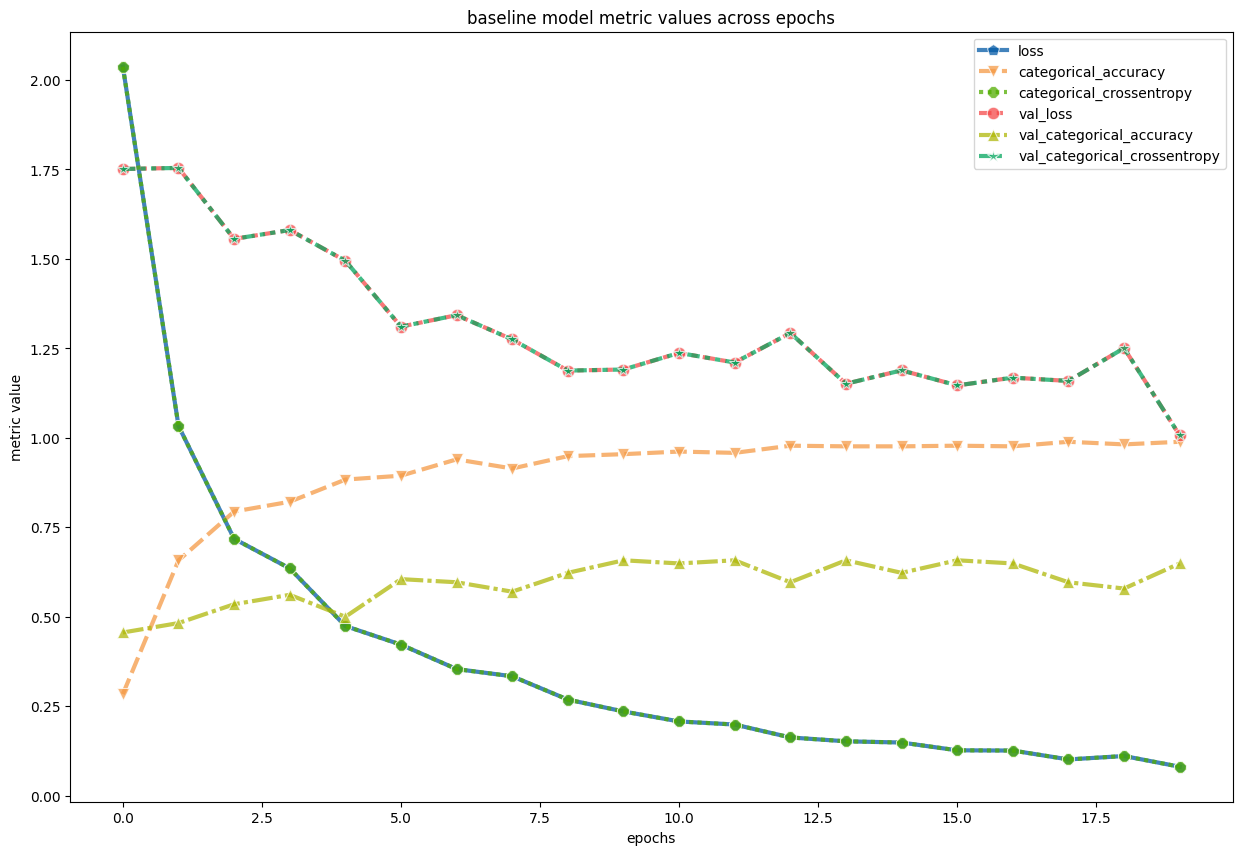

In [43]:
view_all_splits_results(baseline_history.history, save_img=True, img_title='baseline model metric values across epochs')

loss
categorical_accuracy
{'loss': [2.0371458530426025, 1.0334666967391968, 0.7179322838783264, 0.6352515816688538, 0.47421059012413025, 0.42212986946105957, 0.35390737652778625, 0.3337840139865875, 0.2686573565006256, 0.2354557365179062, 0.20758169889450073, 0.19892343878746033, 0.1628660410642624, 0.15204976499080658, 0.14863304793834686, 0.12688741087913513, 0.1262177675962448, 0.10140121728181839, 0.1109594851732254, 0.08104868233203888], 'categorical_accuracy': [0.284153014421463, 0.6575592160224915, 0.7941712141036987, 0.8214936256408691, 0.8834244012832642, 0.8943533897399902, 0.9398906826972961, 0.9143897891044617, 0.9489981532096863, 0.9544626474380493, 0.9617486596107483, 0.9581056237220764, 0.9781420826911926, 0.9763205647468567, 0.9763205647468567, 0.9781420826911926, 0.9763205647468567, 0.9890710115432739, 0.9817850589752197, 0.9890710115432739]}


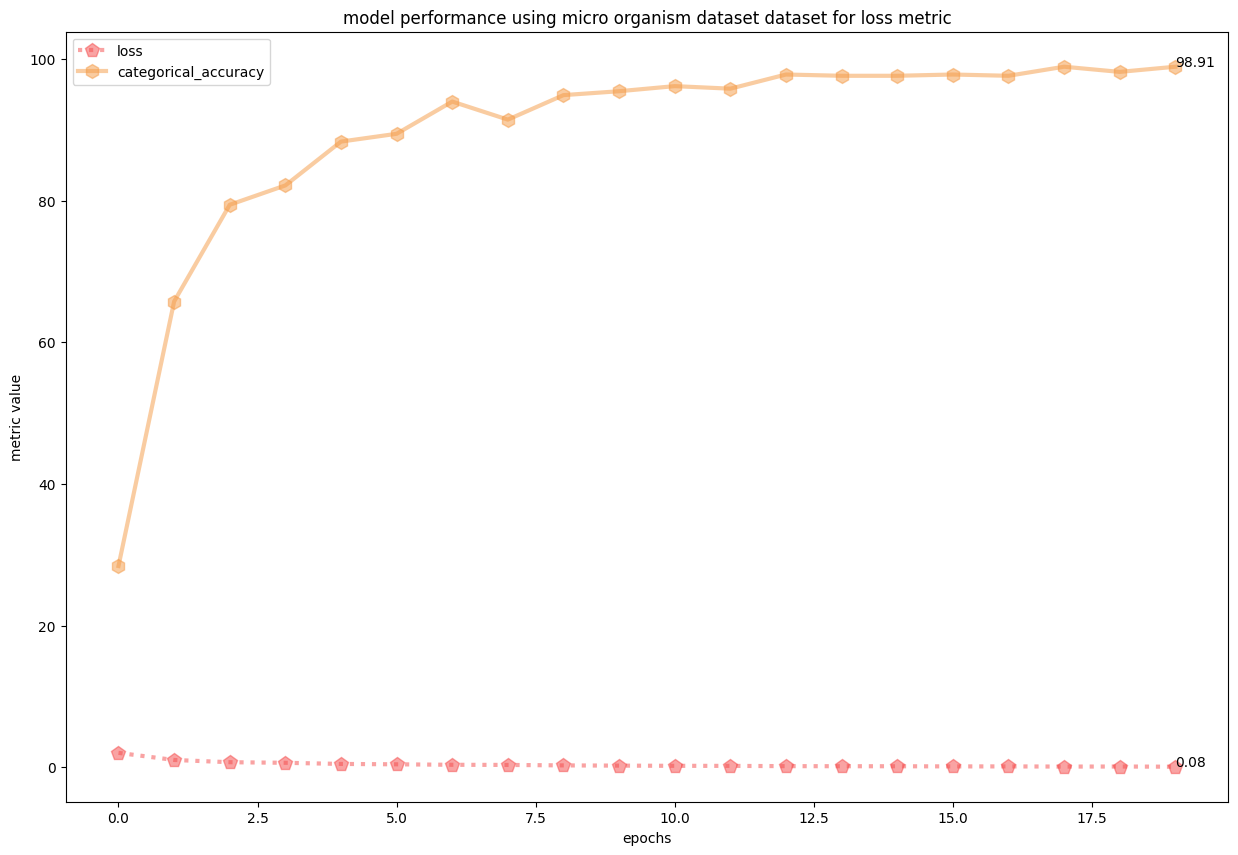

categorical_crossentropy
val_loss
{'categorical_crossentropy': [2.0371458530426025, 1.0334666967391968, 0.7179322838783264, 0.6352515816688538, 0.47421059012413025, 0.42212986946105957, 0.35390737652778625, 0.3337840139865875, 0.2686573565006256, 0.2354557365179062, 0.20758169889450073, 0.19892343878746033, 0.1628660410642624, 0.15204976499080658, 0.14863304793834686, 0.12688741087913513, 0.1262177675962448, 0.10140121728181839, 0.1109594851732254, 0.08104868233203888], 'val_loss': [1.7513741254806519, 1.7543774843215942, 1.5560592412948608, 1.5808196067810059, 1.4948943853378296, 1.3108038902282715, 1.3429465293884277, 1.2750790119171143, 1.1880011558532715, 1.1909971237182617, 1.2373906373977661, 1.2105298042297363, 1.2930394411087036, 1.1512647867202759, 1.1886394023895264, 1.1465872526168823, 1.168306827545166, 1.1591249704360962, 1.2507811784744263, 1.0070160627365112]}


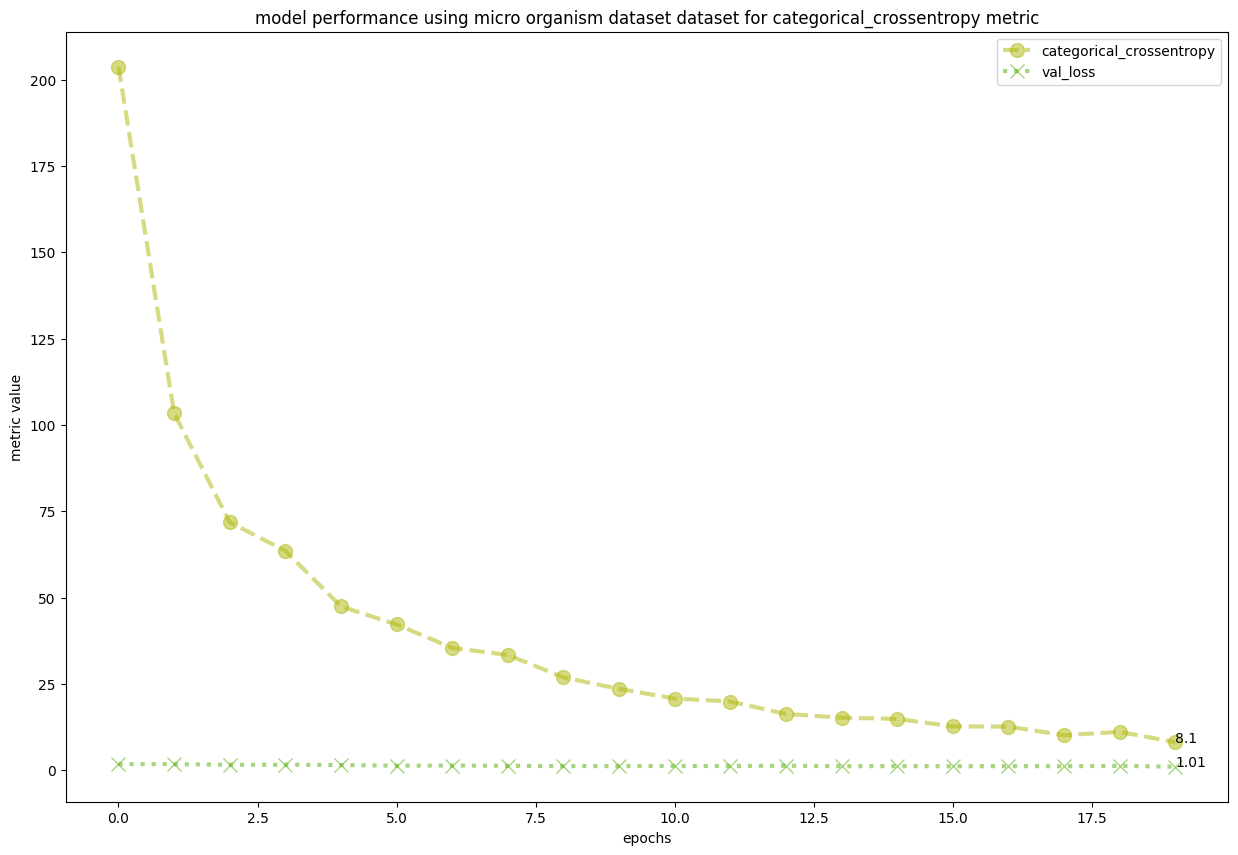

val_categorical_accuracy
val_categorical_crossentropy
{'val_categorical_accuracy': [0.45614033937454224, 0.48245614767074585, 0.5350877046585083, 0.5614035129547119, 0.5, 0.6052631735801697, 0.5964912176132202, 0.5701754093170166, 0.6228070259094238, 0.6578947305679321, 0.6491228342056274, 0.6578947305679321, 0.5964912176132202, 0.6578947305679321, 0.6228070259094238, 0.6578947305679321, 0.6491228342056274, 0.5964912176132202, 0.5789473652839661, 0.6491228342056274], 'val_categorical_crossentropy': [1.7513741254806519, 1.7543774843215942, 1.5560592412948608, 1.5808196067810059, 1.4948943853378296, 1.3108038902282715, 1.3429465293884277, 1.2750790119171143, 1.1880011558532715, 1.1909971237182617, 1.2373906373977661, 1.2105298042297363, 1.2930394411087036, 1.1512647867202759, 1.1886394023895264, 1.1465872526168823, 1.168306827545166, 1.1591249704360962, 1.2507811784744263, 1.0070160627365112]}


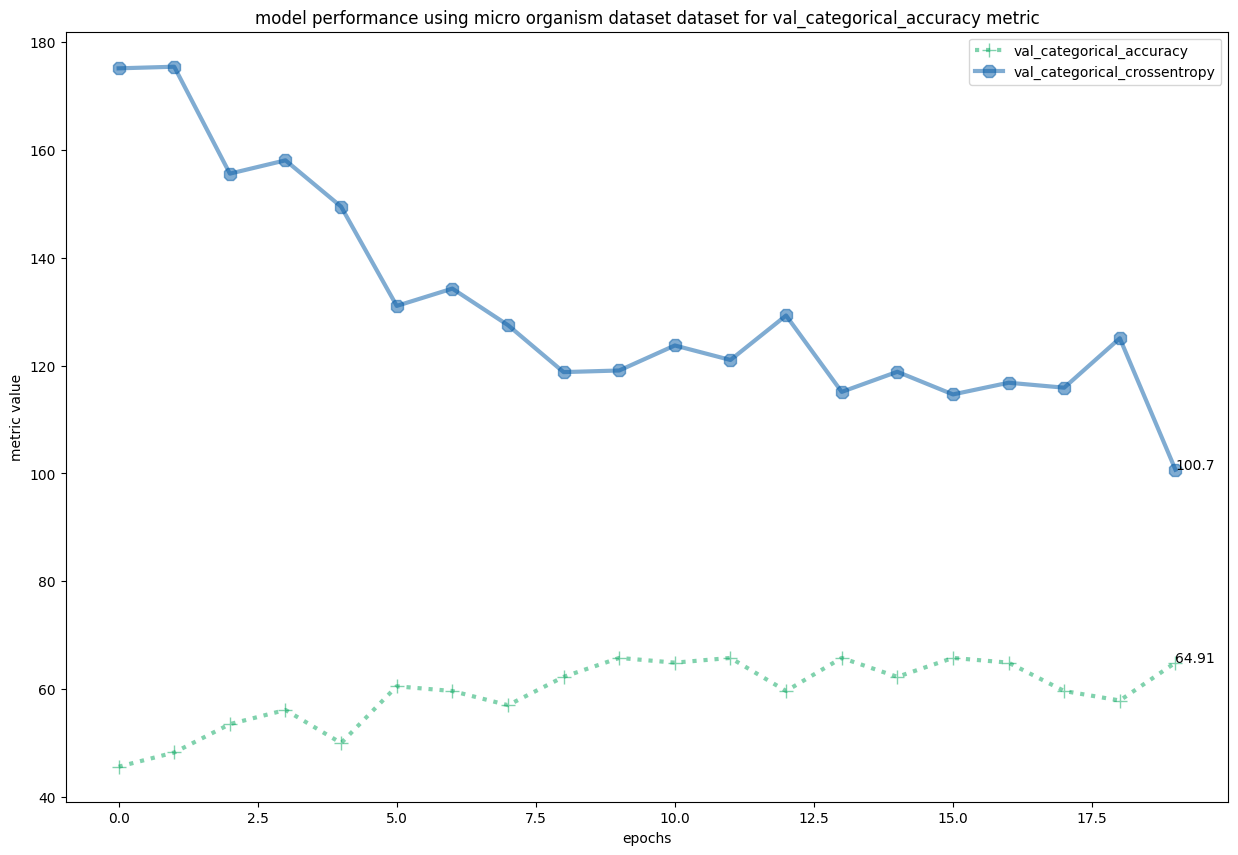

In [47]:
baseline_trained_model_results = ModelResults(baseline_history.history, baseline_history.epoch)
baseline_trained_model_results.export_results(dataset_id="micro organism dataset", metrics_to_use=list(baseline_history.history.keys()), save_img=True)